<a id="title"></a>
# WFC3/UVIS Time-dependent Photometry
***
## Learning Goals
By the end of this tutorial, you will: 
- Compute aperture photometry on FLC frames acquired at three unique epochs and apply the new time-dependent inverse sensitivity (PHOTFLAM) keywords.
- Recompute aperture photometry on modified FLC frames with 'equalized' countrate values.
- Redrizzle the 'equalized' FLC frames and compute aperture photometry on the DRC products.

## Table of Contents
[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Download the data](#data) <br>
[3. Correct for distortion using the Pixel Area Map](#pam) <br>

[4. Compute aperture photometry on the FLC frames](#phot) <br>
- [4.1 Calculate countrates](#calc_phot) <br>
- [4.2 Calculate magnitudes](#calc_mag) <br>
- [4.3 Plot countrate vs date](#plot_count) <br>
- [4.4 Plot magnitude vs date](#plot_mag) <br>

[5. Correct the FLC frames using 'photometric equalization'](#equal) <br>
- [5.1 Recompute countrates](#calc_equal) <br>
- [5.2 Plot corrected countrate vs date](#plot_equal) <br>

[6. Redrizzle the corrected FLC frames for each epoch](#astro) <br>
- [6.1 Recalculate photometry on the new DRC frames](#calc_astro) <br>
- [6.2 Plot DRC countrate vs date](#plot_astro) <br>

[7. Conclusions](#conclusions) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction

For UVIS images retrieved after October 15, 2020, new time-dependent photometry keyword values (PHOTFLAM, PHTFLAM1, PHTFLAM2 and PHTRATIO) are populated in the image header and must be applied separately for each observation epoch. This is a change from prior calibration, where a single set of keyword values were provided for each filter, independent of date. For more detail on the new calibration, see [WFC3 ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf).

In this tutorial, we show how to use the time-dependent calibration to compute aperture photometry on UVIS calibrated, CTE-corrected images (flc.fits, hereafter FLC) obtained at three epochs, spanning a total range of ~8 years and showing a loss in sensitivity of ~2%. The repository includes a CSV file containing a list of FLCs and the centroid of the star in each image, as well as the UVIS Pixel Area Maps to correct for distortion when working with FLC data.

Alternately, the FLC science arrays may be 'equalized' to account for sensitivity changes prior to computing photometry, where a reference set of keywords may be then used for all images. This photometric 'equalization' must be performed before combining any set of FLC images with AstroDrizzle which span multiple epochs in time.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:
- *os* for setting environment variables
- *glob* for finding lists of files
- *shutil* for managing directories

- *numpy* for handling array functions
- *pandas* for managing data
- *matplotlib.pyplot* for plotting data
- *astroquery.mast Observations* for downloading data from MAST

- *astropy* for astronomy related functions
- *drizzlepac* for combining images
- *photutils* for photometric calculations
- *stwcs* for updating the World Coordinate System

In [1]:
import os
import glob
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astroquery.mast import Observations

from drizzlepac import photeq
from drizzlepac import astrodrizzle

from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


<a id="data"></a>
## 2. Download the Data

The following commands query MAST for WFC3/UVIS calibrated (FLC) data products in the F606W filter for three epochs of GD153 observations (acquired in 2009, 2013, and 2017) and then downloads them to the current directory. 

In [2]:
data_list = Observations.query_criteria(obs_id=['IBCDA4010', 'ICH3040F0', 'IDBHA6040'])

Observations.download_products(data_list['obsid'], project='CALWF3',
                               mrp_only=False, download_dir='./data', productSubGroupDescription=['FLC', 'ASN'])

science_files = glob.glob('data/mastDownload/HST/*/*fits')

for im in science_files:
    root = os.path.basename(im)
    new_path = os.path.join("./", root)
    os.rename(im, new_path)
shutil.rmtree('data/')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


For convenience, the file 'GD153_F606W_public.csv' contains information about the images required for the tutorial. For each FLC image, the following is provided: filename, star x-cdt, y-cdt, filter, CCD amplifier, chip, and epoch for the 3 observation dates.

In [3]:
df = pd.read_csv('GD153_F606W_public.csv')
df

,FLC,Centx,Centy,Filter,Amp,Chip,Epoch
0,ibcda4d0q_flc.fits,289.940,285.934,F606W,C,2,1
1,ibcda4d6q_flc.fits,325.855,299.742,F606W,C,2,1
2,ibcda4dcq_flc.fits,312.830,321.911,F606W,C,2,1
3,ibcda4diq_flc.fits,276.756,308.288,F606W,C,2,1
4,ich304prq_flc.fits,246.181,331.752,F606W,C,2,2
5,ich304q1q_flc.fits,248.901,334.022,F606W,C,2,2
6,idbha6ntq_flc.fits,262.719,254.764,F606W,C,2,3
7,idbha6nyq_flc.fits,265.020,257.049,F606W,C,2,3


<a id="pam"></a>
## 3. Correct for distortion using the Pixel Area Map

FLC frames are not corrected for distortion and pixels therefore do not have equal area on the sky. To correct for this affect, we multiply the FLC frames by the [Pixel Area Map (PAM)](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/pixel-area-maps). Since the GD153 data are C512C subarrays, the PAM needs to be "cut out" at the region corresponding to the subarray.

In [4]:
pam1 = fits.getdata('UVIS1wfc3_map.fits')
pam2 = fits.getdata('UVIS2wfc3_map.fits')

pams = {'A': pam1[-512:, :513], 'B': pam1[-512:, -513:], 'C': pam2[:512, :513], 'D': pam2[:512, -513:]}

<a id="phot"></a>
## 4. Compute aperture photometry on the FLC frames

<a id="calc_phot"></a>
### 4.1 Calculate countrates

Here we set up the code that computes the photometry. We are using a standard aperture size of 10 pixels, with a sky annulus from 155 to 165 pixels. These are the steps involved in computing the photometry:

1. Loop through each FLC and load the data, MJD date of exposure, exposure time, and PHOTFLAM.
2. Divide each FLC by the exposure time to get countrates in electrons per second (FLC images are in electrons).
3. Correct for distortion by multiplying by the appropriate cutout of the pixel area map (PAM) corresponding to the subarray region.
4. Supply the x,y coordinate of the star in each image from the CSV file/pandas dataframe.
5. Define the aperture, annulus aperture, and annulus mask.
6. Compute the sigma-clipped mean of the sky annulus.
7. Compute the photometry in the aperture.
8. Subtract the sky background from the photometry derived in the previous step.
9. Store all values.

In [5]:
phots = []
mjds = []
dates = []
ap = 10
skyrad = [155, 165]
pfl = []
for i, flc in enumerate(df['FLC'].values):
    with fits.open(flc) as f:
        data = f[1].data
        mjd = f[0].header['EXPSTART']
        date = f[0].header['DATE-OBS']
        exptime = f[0].header['EXPTIME']
        pfl.append(f[0].header['PHOTFLAM'])
    data = data / exptime
    data = data * pams[df.at[i, 'Amp']]

    positions = (df.at[i, 'Centx'], df.at[i, 'Centy'])
    aperture = CircularAperture(positions, ap)
    annulus_aperture = CircularAnnulus(positions, r_in=skyrad[0], r_out=skyrad[1])
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(data)
    mask = annulus_masks.data
    annulus_data_1d = annulus_data[mask > 0]
    mean_sigclip, _, _ = sigma_clipped_stats(annulus_data_1d)

    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data, apers)

    background = mean_sigclip * aperture.area
    final_sum = phot_table['aperture_sum_0'] - background
    phots.append(final_sum[0])
    mjds.append(mjd)
    dates.append(date)

Next, we append the coutrates, MJD's, and PHOTFLAM values to our dataframe.

In [6]:
df['Countrate'] = phots
df['MJD'] = mjds
df['DATE-OBS'] = dates
df['PHOTFLAM'] = pfl

df

,FLC,Centx,Centy,Filter,Amp,Chip,Epoch,Countrate,MJD,DATE-OBS,PHOTFLAM
0,ibcda4d0q_flc.fits,289.940,285.934,F606W,C,2,1,103300.375759,55170.563332,2009-12-05,1.153991e-19
1,ibcda4d6q_flc.fits,325.855,299.742,F606W,C,2,1,103292.263099,55170.569026,2009-12-05,1.153991e-19
2,ibcda4dcq_flc.fits,312.830,321.911,F606W,C,2,1,103661.304094,55170.574721,2009-12-05,1.153991e-19
3,ibcda4diq_flc.fits,276.756,308.288,F606W,C,2,1,103448.275067,55170.620196,2009-12-05,1.153992e-19
4,ich304prq_flc.fits,246.181,331.752,F606W,C,2,2,102471.856752,56629.866744,2013-12-03,1.163887e-19
5,ich304q1q_flc.fits,248.901,334.022,F606W,C,2,2,102744.163768,56629.877033,2013-12-03,1.163887e-19
6,idbha6ntq_flc.fits,262.719,254.764,F606W,C,2,3,101822.822242,58068.856082,2017-11-11,1.173665e-19
7,idbha6nyq_flc.fits,265.020,257.049,F606W,C,2,3,101553.087031,58068.861359,2017-11-11,1.173665e-19


<a id="calc_mag"></a>
### 4.2 Calculate magnitudes

We now convert countrates into ST magnitudes using the PHOTFLAM value and the following equation. The $EE_{r10}$ is the encircled energy term for an aperture radius of r=10 pixels (0.4 arcseconds). For F606W with UVIS2, this is 0.91. This value can be computed using `stsynphot` as described in the 'Photometry Examples' notebook in this WFC3 Library repository.

In [7]:
EE_r10 = 0.91
df["STMags"] = (
    - 21.1
    - 2.5 * np.log10(df["PHOTFLAM"])
    - 2.5 * np.log10(df["Countrate"])
    - 2.5 * np.log10(1.0 / EE_r10)
)

In [8]:
df

,FLC,Centx,Centy,Filter,Amp,Chip,Epoch,Countrate,MJD,DATE-OBS,PHOTFLAM,STMags
0,ibcda4d0q_flc.fits,289.940,285.934,F606W,C,2,1,103300.375759,55170.563332,2009-12-05,1.153991e-19,13.606843
1,ibcda4d6q_flc.fits,325.855,299.742,F606W,C,2,1,103292.263099,55170.569026,2009-12-05,1.153991e-19,13.606928
2,ibcda4dcq_flc.fits,312.830,321.911,F606W,C,2,1,103661.304094,55170.574721,2009-12-05,1.153991e-19,13.603055
3,ibcda4diq_flc.fits,276.756,308.288,F606W,C,2,1,103448.275067,55170.620196,2009-12-05,1.153992e-19,13.605289
4,ich304prq_flc.fits,246.181,331.752,F606W,C,2,2,102471.856752,56629.866744,2013-12-03,1.163887e-19,13.606315
5,ich304q1q_flc.fits,248.901,334.022,F606W,C,2,2,102744.163768,56629.877033,2013-12-03,1.163887e-19,13.603434
6,idbha6ntq_flc.fits,262.719,254.764,F606W,C,2,3,101822.822242,58068.856082,2017-11-11,1.173665e-19,13.604131
7,idbha6nyq_flc.fits,265.020,257.049,F606W,C,2,3,101553.087031,58068.861359,2017-11-11,1.173665e-19,13.607010


<a id="plot_count"></a>
### 4.3 Plot countrate vs date

We first plot the photometric countrates (electrons per second) vs time in MJD. The decline in the observed countrate is due to sensitivity loss in F606W at a rate of ~0.2% per year.

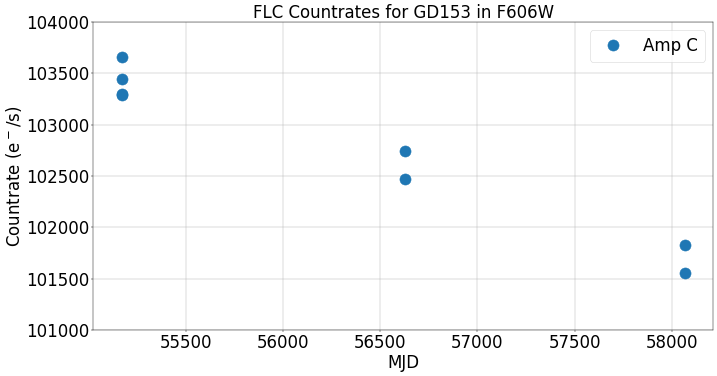

In [9]:
fig = plt.figure(figsize=(20, 10), dpi=40)

plt.plot(df['MJD'], df['Countrate'], 'o', markersize=20, label='Amp C')
plt.grid()
plt.xlabel('MJD', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel(r'Countrate (e$^-$/s)', fontsize=30)
plt.title('FLC Countrates for GD153 in F606W', fontsize=30)
plt.ylim(101000, 104000)
plt.legend(loc=0, fontsize=30)

<a id="plot_mag"></a>
### 4.4 Plot magnitude vs date

Now, we plot the ST magnitude versus time in MJD. This is computed using the 'corrected' PHOTFLAM keyword, so the magnitude values are stable over time.

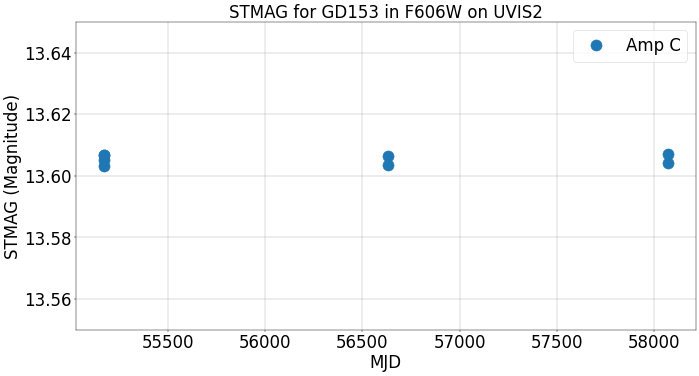

In [10]:
fig = plt.figure(figsize=(20, 10), dpi=40)

plt.plot(df['MJD'], df['STMags'], 'o', markersize=20, label='Amp C')
plt.grid()
plt.ticklabel_format(useOffset=False)
plt.xlabel('MJD', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('STMAG (Magnitude)', fontsize=30)
plt.ylim(13.55, 13.65)
plt.title('STMAG for GD153 in F606W on UVIS2', fontsize=30)
plt.legend(loc=0, fontsize=30)

<a id="equal"></a>
## 5. Correct the FLC frames using 'photometric equalization'

This single-line step will equalize the countrates in the science array of the FLC frames to match any specified 'reference' image. For more details, see the drizzlepac documentation for the [phot_eq software](https://drizzlepac.readthedocs.io/en/latest/photeq.html). Note that at this step, we overwrite the science pixels in the original FLC files. In this case the data are sorted, and the software automatically uses the PHOTFLAM value of the first 2009 image as a reference for matching the with the other images. You can supply a given reference PHOTFLAM value to the photeq call and/or ensure that your data are time-sorted.

**Note: Running this cell will edit the FLCs in the local directory, and you will need to download the files again if you require the original data.**

In [11]:
photeq.photeq(','.join(df['FLC'].values), readonly=False)

***** photeq started on 2024-01-05 19:59:37.103983


      Version 3.5.1 


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'ibcda4d0q_flc.fits[0]'


REFERENCE 'PHOTFLAM' VALUE IS: 1.1539911e-19


Processing file 'ibcda4d0q_flc.fits'


   * Primary header:


     - 'PHOTFLAM' = 1.1539911e-19 found in the primary header.


     - Data conversion factor based on primary header: 1.0


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1539911e-19)


     - Computed conversion factor for data: 1.0


     - Setting PHOTFNU to 1.3456969e-07 (old value was 1.3456969e-07)


     - Data have been multiplied by 1.0


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0


Processing file 'ibcda4d6q_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1539913e-19)


     - Data conversion factor based on primary header: 1.0000001733115618


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1539913e-19)


     - Computed conversion factor for data: 1.0000001733115618


     - Setting PHOTFNU to 1.345696666775209e-07 (old value was 1.3456969e-07)


     - Data have been multiplied by 1.0000001733115618


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0000001733115618


Processing file 'ibcda4dcq_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1539913e-19)


     - Data conversion factor based on primary header: 1.0000001733115618


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1539913e-19)


     - Computed conversion factor for data: 1.0000001733115618


     - Setting PHOTFNU to 1.345696666775209e-07 (old value was 1.3456969e-07)


     - Data have been multiplied by 1.0000001733115618


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0000001733115618


Processing file 'ibcda4diq_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1539915e-19)


     - Data conversion factor based on primary header: 1.000000346623124


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1539915e-19)


     - Computed conversion factor for data: 1.000000346623124


     - Setting PHOTFNU to 1.3456968335503596e-07 (old value was 1.3456973e-07)


     - Data have been multiplied by 1.000000346623124


     - Error array (ext=('ERR', 1)) has been multiplied by 1.000000346623124


Processing file 'ich304prq_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1638865e-19)


     - Data conversion factor based on primary header: 1.0085749361498544


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1638865e-19)


     - Computed conversion factor for data: 1.0085749361498544


     - Setting PHOTFNU to 1.3434231324172846e-07 (old value was 1.3549429e-07)


     - Data have been multiplied by 1.0085749361498544


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0085749361498544


Processing file 'ich304q1q_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1638865e-19)


     - Data conversion factor based on primary header: 1.0085749361498544


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1638865e-19)


     - Computed conversion factor for data: 1.0085749361498544


     - Setting PHOTFNU to 1.3434232315670814e-07 (old value was 1.354943e-07)


     - Data have been multiplied by 1.0085749361498544


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0085749361498544


Processing file 'idbha6ntq_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1736647e-19)


     - Data conversion factor based on primary header: 1.0170483117244147


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1736647e-19)


     - Computed conversion factor for data: 1.0170483117244147


     - Setting PHOTFNU to 1.3411951863793208e-07 (old value was 1.3640603e-07)


     - Data have been multiplied by 1.0170483117244147


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0170483117244147


Processing file 'idbha6nyq_flc.fits'


   * Primary header:


     - 'PHOTFLAM' found in the primary header.


     - Setting PHOTFLAM in the primary header to 1.1539911e-19 (old value was 1.1736649e-19)


     - Data conversion factor based on primary header: 1.0170484850359764


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 1.1539911e-19 (old value was 1.1736649e-19)


     - Computed conversion factor for data: 1.0170484850359764


     - Setting PHOTFNU to 1.3411949578310894e-07 (old value was 1.3640603e-07)


     - Data have been multiplied by 1.0170484850359764


     - Error array (ext=('ERR', 1)) has been multiplied by 1.0170484850359764


Done.


<a id="calc_equal"></a>
### 5.1 Recompute countrates

We repeat the same aperture photometry as in [Section 4.1](#calc_phot) but using the photometrically equalized FLC data.

In [12]:
phots = []
for i, flc in enumerate(df['FLC'].values):
    with fits.open(flc) as f:
        data = f[1].data
        exptime = f[0].header['EXPTIME']
    data = data / exptime
    data = data * pams[df.at[i, 'Amp']]

    positions = (df.at[i, 'Centx'], df.at[i, 'Centy'])
    aperture = CircularAperture(positions, ap)
    annulus_aperture = CircularAnnulus(positions, r_in=skyrad[0], r_out=skyrad[1])
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(data)
    mask = annulus_masks.data
    annulus_data_1d = annulus_data[mask > 0]
    mean_sigclip, _, _ = sigma_clipped_stats(annulus_data_1d)
    background = mean_sigclip * aperture.area

    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data, apers)

    final_sum = phot_table['aperture_sum_0'] - background
    phots.append(final_sum[0])
    mjds.append(mjd)

We'll append the photometrically equalized countrates to our dataframe.

In [13]:
df['Phot-eq'] = phots

In [14]:
df

,FLC,Centx,Centy,Filter,Amp,Chip,Epoch,Countrate,MJD,DATE-OBS,PHOTFLAM,STMags,Phot-eq
0,ibcda4d0q_flc.fits,289.940,285.934,F606W,C,2,1,103300.375759,55170.563332,2009-12-05,1.153991e-19,13.606843,103300.375759
1,ibcda4d6q_flc.fits,325.855,299.742,F606W,C,2,1,103292.263099,55170.569026,2009-12-05,1.153991e-19,13.606928,103292.274260
2,ibcda4dcq_flc.fits,312.830,321.911,F606W,C,2,1,103661.304094,55170.574721,2009-12-05,1.153991e-19,13.603055,103661.316241
3,ibcda4diq_flc.fits,276.756,308.288,F606W,C,2,1,103448.275067,55170.620196,2009-12-05,1.153992e-19,13.605289,103448.313094
4,ich304prq_flc.fits,246.181,331.752,F606W,C,2,2,102471.856752,56629.866744,2013-12-03,1.163887e-19,13.606315,103350.548848
5,ich304q1q_flc.fits,248.901,334.022,F606W,C,2,2,102744.163768,56629.877033,2013-12-03,1.163887e-19,13.603434,103625.191460
6,idbha6ntq_flc.fits,262.719,254.764,F606W,C,2,3,101822.822242,58068.856082,2017-11-11,1.173665e-19,13.604131,103558.735918
7,idbha6nyq_flc.fits,265.020,257.049,F606W,C,2,3,101553.087031,58068.861359,2017-11-11,1.173665e-19,13.607010,103284.414246


<a id="plot_equal"></a>
### 5.2 Plot corrected countrate vs date

We plot the photometric countrate (electrons per second) versus time in MJD. The corrected data in blue shows that the countrate is now ~flat over time to within the measurment errors. The original countrates are shown in grey and show a decline of nearly 2% over the three epochs.

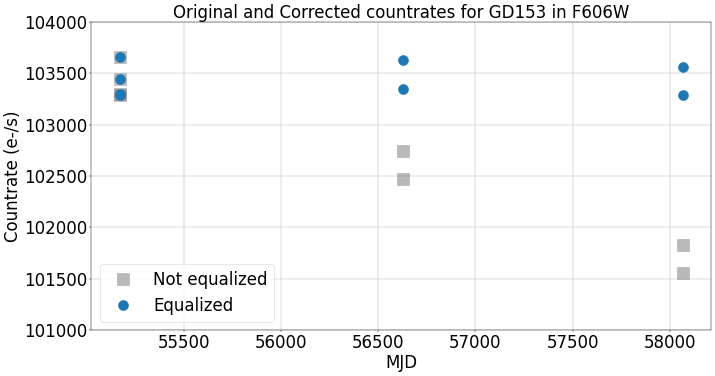

In [15]:
fig = plt.figure(figsize=(20, 10), dpi=40)

plt.plot(df['MJD'], df['Countrate'], 's', markersize=20, label='Not equalized', alpha=0.55, color='Grey')
plt.plot(df['MJD'], df['Phot-eq'], 'o', markersize=18, label='Equalized')
plt.grid()
plt.xlabel('MJD', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Countrate (e-/s)', fontsize=30)
plt.title('Original and Corrected countrates for GD153 in F606W', fontsize=30)
plt.ylim(101000, 104000)
plt.legend(loc=0, fontsize=30)

<a id="astro"></a>
## 6. Redrizzle the corrected FLC frames for each epoch

The corrected FLC data from each epoch can now be redrizzled to correct for distortion, to remove cosmic rays and bad pixels, and to improve the signal-to-noise in the combined DRC product at each date. (Alternately, the entire set of FLC images may be combined to produce a single DRC image to use for photometry.)

**Warning: This cell may take a few minutes to complete.**

In [16]:
for asn in glob.glob("*asn.fits"):
    astrodrizzle.AstroDrizzle(
        asn,
        skymethod="match",
        skystat="mean",
        driz_sep_bits="80",
        combine_type="median",
        combine_nhigh=1,
        driz_cr_snr="3.5 3.0",
        driz_cr_scale="2.0 1.5",
        final_bits="80",
        build=True,
        clean=True,
        preserve=False,
        num_cores=1,
    )

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 19:59:37.593 (05/01/2024)


==== Processing Step  Initialization  started at  19:59:37.59 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25951624762996  22.03131176266394  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.0852229209196698e-05  1.8306773585025585e-06  


CD2_1 CD2_2  : 1.8306773585025585e-06  -1.0852229209196698e-05  


NAXIS : 518  546


********************************************************************************


*


*  Estimated memory usage:  up to 5 Mb.


*  Output image size:       518 X 546 pixels. 


*  Output image file:       ~ 3 Mb. 


*  Cores available:         1


*


********************************************************************************


==== Processing Step Initialization finished at 19:59:37.833 (05/01/2024)


==== Processing Step  Static Mask  started at  19:59:37.835 (05/01/2024)


==== Processing Step Static Mask finished at 19:59:37.847 (05/01/2024)


==== Processing Step  Subtract Sky  started at  19:59:37. (05/01/2024)


***** skymatch started on 2024-01-05 19:59:37.869722


      Version 1.0.9


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'ich304prq_flc.fits'


       EXT: 'SCI',1;	MASK: ich304prq_skymatch_mask_sci1.fits[0]


   **  Input image: 'ich304q1q_flc.fits'


       EXT: 'SCI',1;	MASK: ich304q1q_skymatch_mask_sci1.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'mean'


       lower = None


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.1


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: ich304prq_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 3.0 [s]


             Conversion factor (data->brightness):  212.3487866626491


   *   Image: ich304q1q_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 3.0 [s]


             Conversion factor (data->brightness):  212.3487866626491


-----  Computing differences in sky values in overlapping regions:  -----


   *   Image 'ich304prq_flc.fits['SCI',1]' SKY = 3.05637 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0143932


   *   Image 'ich304q1q_flc.fits['SCI',1]' SKY = 0 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


***** skymatch ended on 2024-01-05 19:59:38.151227


TOTAL RUN TIME: 0:00:00.281505


==== Processing Step Subtract Sky finished at 19:59:38.176 (05/01/2024)


==== Processing Step  Separate Drizzle  started at  19:59:38.177 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25951624762996  22.03131176266394  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.0852229209196698e-05  1.8306773585025585e-06  


CD2_1 CD2_2  : 1.8306773585025585e-06  -1.0852229209196698e-05  


NAXIS : 518  546


-Generating simple FITS output: ich304prq_single_sci.fits


Writing out image to disk: ich304prq_single_sci.fits


Writing out image to disk: ich304prq_single_wht.fits


-Generating simple FITS output: ich304q1q_single_sci.fits


Writing out image to disk: ich304q1q_single_sci.fits


Writing out image to disk: ich304q1q_single_wht.fits


==== Processing Step Separate Drizzle finished at 19:59:38.595 (05/01/2024)


==== Processing Step  Create Median  started at  19:59:38.596 (05/01/2024)


reference sky value for image 'ich304prq_flc.fits' is 0.014393150806426957


reference sky value for image 'ich304q1q_flc.fits' is 0.0


Saving output median image to: 'ich3040f0_med.fits'


==== Processing Step Create Median finished at 19:59:38.645 (05/01/2024)


==== Processing Step  Blot  started at  19:59:38.645 (05/01/2024)


    Blot: creating blotted image:  ich304prq_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ich304prq_sci1_blt.fits


Writing out image to disk: ich304prq_sci1_blt.fits


    Blot: creating blotted image:  ich304q1q_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ich304q1q_sci1_blt.fits


Writing out image to disk: ich304q1q_sci1_blt.fits


==== Processing Step Blot finished at 19:59:38.850 (05/01/2024)


==== Processing Step  Driz_CR  started at  19:59:38.851 (05/01/2024)


Creating output: ich304prq_sci1_crmask.fits


Creating output: ich304q1q_sci1_crmask.fits


==== Processing Step Driz_CR finished at 19:59:38.925 (05/01/2024)


==== Processing Step  Final Drizzle  started at  19:59:38.926 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25951624762996  22.03131176266394  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.0852229209196698e-05  1.8306773585025585e-06  


CD2_1 CD2_2  : 1.8306773585025585e-06  -1.0852229209196698e-05  


NAXIS : 518  546


-Generating multi-extension output file:  ich3040f0_drc.fits


Deleted all instances of WCS with key A in extensions [1]


Writing out to disk: ich3040f0_drc.fits


==== Processing Step Final Drizzle finished at 19:59:39.519 (05/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 19:59:39.521 (05/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2385 sec.


            Static Mask          0.0121 sec.


           Subtract Sky          0.3285 sec.


       Separate Drizzle          0.4182 sec.


          Create Median          0.0489 sec.


                   Blot          0.2052 sec.


                Driz_CR          0.0739 sec.


          Final Drizzle          0.5935 sec.


   ====================          ====================


                  Total          1.9189 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 19:59:39.560 (05/01/2024)


==== Processing Step  Initialization  started at  19:59:39.56 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25889677942757  22.031359382198254  


CRPIX : 282.5  290.5  


CD1_1 CD1_2  : 1.082347140916146e-05  1.9936712504674146e-06  


CD2_1 CD2_2  : 1.9936712504674146e-06  -1.082347140916146e-05  


NAXIS : 565  581


********************************************************************************


*


*  Estimated memory usage:  up to 5 Mb.


*  Output image size:       565 X 581 pixels. 


*  Output image file:       ~ 3 Mb. 


*  Cores available:         1


*


********************************************************************************


==== Processing Step Initialization finished at 19:59:40.025 (05/01/2024)


==== Processing Step  Static Mask  started at  19:59:40.027 (05/01/2024)


==== Processing Step Static Mask finished at 19:59:40.045 (05/01/2024)


==== Processing Step  Subtract Sky  started at  19:59:40.046 (05/01/2024)


***** skymatch started on 2024-01-05 19:59:40.182719


      Version 1.0.9


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'ibcda4d0q_flc.fits'


       EXT: 'SCI',1;	MASK: ibcda4d0q_skymatch_mask_sci1.fits[0]


   **  Input image: 'ibcda4d6q_flc.fits'


       EXT: 'SCI',1;	MASK: ibcda4d6q_skymatch_mask_sci1.fits[0]


   **  Input image: 'ibcda4dcq_flc.fits'


       EXT: 'SCI',1;	MASK: ibcda4dcq_skymatch_mask_sci1.fits[0]


   **  Input image: 'ibcda4diq_flc.fits'


       EXT: 'SCI',1;	MASK: ibcda4diq_skymatch_mask_sci1.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'mean'


       lower = None


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.1


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: ibcda4d0q_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 1.0 [s]


             Conversion factor (data->brightness):  637.0463599879473


   *   Image: ibcda4d6q_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 1.0 [s]


             Conversion factor (data->brightness):  637.0463599879473


   *   Image: ibcda4dcq_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 1.0 [s]


             Conversion factor (data->brightness):  637.0463599879473


   *   Image: ibcda4diq_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 1.0 [s]


             Conversion factor (data->brightness):  637.0463599879473


-----  Computing differences in sky values in overlapping regions:  -----


   *   Image 'ibcda4d0q_flc.fits['SCI',1]' SKY = 68.4183 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.107399


   *   Image 'ibcda4d6q_flc.fits['SCI',1]' SKY = 10.3393 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0162301


   *   Image 'ibcda4dcq_flc.fits['SCI',1]' SKY = 12.4503 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0195437


   *   Image 'ibcda4diq_flc.fits['SCI',1]' SKY = 0 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


***** skymatch ended on 2024-01-05 19:59:41.547189


TOTAL RUN TIME: 0:00:01.364470


==== Processing Step Subtract Sky finished at 19:59:41.597 (05/01/2024)


==== Processing Step  Separate Drizzle  started at  19:59:41.597 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25889677942757  22.031359382198254  


CRPIX : 282.5  290.5  


CD1_1 CD1_2  : 1.082347140916146e-05  1.9936712504674146e-06  


CD2_1 CD2_2  : 1.9936712504674146e-06  -1.082347140916146e-05  


NAXIS : 565  581


-Generating simple FITS output: ibcda4d0q_single_sci.fits


Writing out image to disk: ibcda4d0q_single_sci.fits


Writing out image to disk: ibcda4d0q_single_wht.fits


-Generating simple FITS output: ibcda4d6q_single_sci.fits


Writing out image to disk: ibcda4d6q_single_sci.fits


Writing out image to disk: ibcda4d6q_single_wht.fits


-Generating simple FITS output: ibcda4dcq_single_sci.fits


Writing out image to disk: ibcda4dcq_single_sci.fits


Writing out image to disk: ibcda4dcq_single_wht.fits


-Generating simple FITS output: ibcda4diq_single_sci.fits


Writing out image to disk: ibcda4diq_single_sci.fits


Writing out image to disk: ibcda4diq_single_wht.fits


==== Processing Step Separate Drizzle finished at 19:59:42. (05/01/2024)


==== Processing Step  Create Median  started at  19:59:42.258 (05/01/2024)


reference sky value for image 'ibcda4d0q_flc.fits' is 0.10739920657268735


reference sky value for image 'ibcda4d6q_flc.fits' is 0.016230068945693298


reference sky value for image 'ibcda4dcq_flc.fits' is 0.01954372089581475


reference sky value for image 'ibcda4diq_flc.fits' is 0.0


Saving output median image to: 'ibcda4010_med.fits'


==== Processing Step Create Median finished at 19:59:42.339 (05/01/2024)


==== Processing Step  Blot  started at  19:59:42.340 (05/01/2024)


    Blot: creating blotted image:  ibcda4d0q_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ibcda4d0q_sci1_blt.fits


Writing out image to disk: ibcda4d0q_sci1_blt.fits


    Blot: creating blotted image:  ibcda4d6q_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ibcda4d6q_sci1_blt.fits


Writing out image to disk: ibcda4d6q_sci1_blt.fits


    Blot: creating blotted image:  ibcda4dcq_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ibcda4dcq_sci1_blt.fits


Writing out image to disk: ibcda4dcq_sci1_blt.fits


    Blot: creating blotted image:  ibcda4diq_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ibcda4diq_sci1_blt.fits


Writing out image to disk: ibcda4diq_sci1_blt.fits


==== Processing Step Blot finished at 19:59:42.758 (05/01/2024)


==== Processing Step  Driz_CR  started at  19:59:42.758 (05/01/2024)


Creating output: ibcda4d0q_sci1_crmask.fits


Creating output: ibcda4d6q_sci1_crmask.fits


Creating output: ibcda4dcq_sci1_crmask.fits


Creating output: ibcda4diq_sci1_crmask.fits


==== Processing Step Driz_CR finished at 19:59:42.9 (05/01/2024)


==== Processing Step  Final Drizzle  started at  19:59:42.907 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25889677942757  22.031359382198254  


CRPIX : 282.5  290.5  


CD1_1 CD1_2  : 1.082347140916146e-05  1.9936712504674146e-06  


CD2_1 CD2_2  : 1.9936712504674146e-06  -1.082347140916146e-05  


NAXIS : 565  581


-Generating multi-extension output file:  ibcda4010_drc.fits


Deleted all instances of WCS with key A in extensions [1]


Writing out to disk: ibcda4010_drc.fits


==== Processing Step Final Drizzle finished at 19:59:43.866 (05/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 19:59:43.867 (05/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.4634 sec.


            Static Mask          0.0186 sec.


           Subtract Sky          1.5504 sec.


       Separate Drizzle          0.6602 sec.


          Create Median          0.0811 sec.


                   Blot          0.4175 sec.


                Driz_CR          0.1475 sec.


          Final Drizzle          0.9588 sec.


   ====================          ====================


                  Total          4.2974 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 19:59:43.911 (05/01/2024)


==== Processing Step  Initialization  started at  19:59:43.913 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25946702548598  22.030300403212255  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.1001745311092143e-05  -2.8958333815648194e-07  


CD2_1 CD2_2  : -2.8958333815648194e-07  -1.1001745311092143e-05  


NAXIS : 518  546


********************************************************************************


*


*  Estimated memory usage:  up to 5 Mb.


*  Output image size:       518 X 546 pixels. 


*  Output image file:       ~ 3 Mb. 


*  Cores available:         1


*


********************************************************************************


==== Processing Step Initialization finished at 19:59:44.149 (05/01/2024)


==== Processing Step  Static Mask  started at  19:59:44.151 (05/01/2024)


==== Processing Step Static Mask finished at 19:59:44.163 (05/01/2024)


==== Processing Step  Subtract Sky  started at  19:59:44.16 (05/01/2024)


***** skymatch started on 2024-01-05 19:59:44.185712


      Version 1.0.9


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'idbha6ntq_flc.fits'


       EXT: 'SCI',1;	MASK: idbha6ntq_skymatch_mask_sci1.fits[0]


   **  Input image: 'idbha6nyq_flc.fits'


       EXT: 'SCI',1;	MASK: idbha6nyq_skymatch_mask_sci1.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'mean'


       lower = None


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.1


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: idbha6ntq_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 3.0 [s]


             Conversion factor (data->brightness):  212.3487866626491


   *   Image: idbha6nyq_flc.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 3.0 [s]


             Conversion factor (data->brightness):  212.3487866626491


-----  Computing differences in sky values in overlapping regions:  -----


   *   Image 'idbha6ntq_flc.fits['SCI',1]' SKY = 0 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


   *   Image 'idbha6nyq_flc.fits['SCI',1]' SKY = 0.535884 [brightness units]


       Updating sky of image extension(s) [data units]:


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0025236


***** skymatch ended on 2024-01-05 19:59:44.470767


TOTAL RUN TIME: 0:00:00.285055


==== Processing Step Subtract Sky finished at 19:59:44.494 (05/01/2024)


==== Processing Step  Separate Drizzle  started at  19:59:44.495 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25946702548598  22.030300403212255  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.1001745311092143e-05  -2.8958333815648194e-07  


CD2_1 CD2_2  : -2.8958333815648194e-07  -1.1001745311092143e-05  


NAXIS : 518  546


-Generating simple FITS output: idbha6ntq_single_sci.fits


Writing out image to disk: idbha6ntq_single_sci.fits


Writing out image to disk: idbha6ntq_single_wht.fits


-Generating simple FITS output: idbha6nyq_single_sci.fits


Writing out image to disk: idbha6nyq_single_sci.fits


Writing out image to disk: idbha6nyq_single_wht.fits


==== Processing Step Separate Drizzle finished at 19:59:44.838 (05/01/2024)


==== Processing Step  Create Median  started at  19:59:44.839 (05/01/2024)


reference sky value for image 'idbha6ntq_flc.fits' is 0.0


reference sky value for image 'idbha6nyq_flc.fits' is 0.0025236010551451834


Saving output median image to: 'idbha6040_med.fits'


==== Processing Step Create Median finished at 19:59:44.884 (05/01/2024)


==== Processing Step  Blot  started at  19:59:44.885 (05/01/2024)


    Blot: creating blotted image:  idbha6ntq_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: idbha6ntq_sci1_blt.fits


Writing out image to disk: idbha6ntq_sci1_blt.fits


    Blot: creating blotted image:  idbha6nyq_flc.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: idbha6nyq_sci1_blt.fits


Writing out image to disk: idbha6nyq_sci1_blt.fits


==== Processing Step Blot finished at 19:59:45.090 (05/01/2024)


==== Processing Step  Driz_CR  started at  19:59:45.091 (05/01/2024)


Creating output: idbha6ntq_sci1_crmask.fits


Creating output: idbha6nyq_sci1_crmask.fits


==== Processing Step Driz_CR finished at 19:59:45.165 (05/01/2024)


==== Processing Step  Final Drizzle  started at  19:59:45.166 (05/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 194.25946702548598  22.030300403212255  


CRPIX : 259.0  273.0  


CD1_1 CD1_2  : 1.1001745311092143e-05  -2.8958333815648194e-07  


CD2_1 CD2_2  : -2.8958333815648194e-07  -1.1001745311092143e-05  


NAXIS : 518  546


-Generating multi-extension output file:  idbha6040_drc.fits


Deleted all instances of WCS with key A in extensions [1]


Writing out to disk: idbha6040_drc.fits


==== Processing Step Final Drizzle finished at 19:59:45.748 (05/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 19:59:45.749 (05/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2360 sec.


            Static Mask          0.0114 sec.


           Subtract Sky          0.3311 sec.


       Separate Drizzle          0.3425 sec.


          Create Median          0.0455 sec.


                   Blot          0.2054 sec.


                Driz_CR          0.0741 sec.


          Final Drizzle          0.5822 sec.


   ====================          ====================


                  Total          1.8283 sec.


Trailer file written to:  astrodrizzle.log


In [17]:
drcs = ['ibcda4010_drc.fits', 'ich3040f0_drc.fits', 'idbha6040_drc.fits']
drcents = [(327.9, 341.4), (251.1, 350.0), (266.6, 273.6)]

<a id="calc_astro"></a>
### 6.1 Recalculate photometry on the new DRC frames

We now perform the photometry on the drizzled (DRC) products, using similar techniques as in [Section 4.1](#calc_phot). Drizzled images are in units of electrons per second are already corrected for distortion, so we no longer need to divide by the exposure time or apply the PAM prior to computing photometry.

In [18]:
phots = []
mjds = []
pfls = []
for i, drc in enumerate(drcs):
    data = fits.getdata(drc, ext=1)

    mjds.append(np.mean(df.query('Epoch == {}'.format(i+1))['MJD']))
    pfls.append(df.query('Epoch == {}'.format(i+1))['PHOTFLAM'].values[0])

    positions = drcents[i]
    aperture = CircularAperture(positions, ap)
    annulus_aperture = CircularAnnulus(positions, r_in=skyrad[0], r_out=skyrad[1])
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(data)
    mask = annulus_masks.data
    annulus_data_1d = annulus_data[mask > 0]
    mean_sigclip, _, _ = sigma_clipped_stats(annulus_data_1d)
    background = mean_sigclip * aperture.area
 
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data, apers)

    final_sum = phot_table['aperture_sum_0'] - background
    phots.append(final_sum[0])

In [19]:
mags = -21.1 - 2.5*np.log10(pfls[0]) - 2.5*np.log10(phots) - 2.5*np.log10(1./EE_r10)
print(mags)

[13.60509474 13.60322196 13.60502308]


<a id="plot_astro"></a>
### 6.2 Plot DRC countrate vs date

The corrected photometric countrate from the DRC and the recomputed magnitudes are plotted below. Note how they agree with the results from the previous step using the FLC and the PAM.

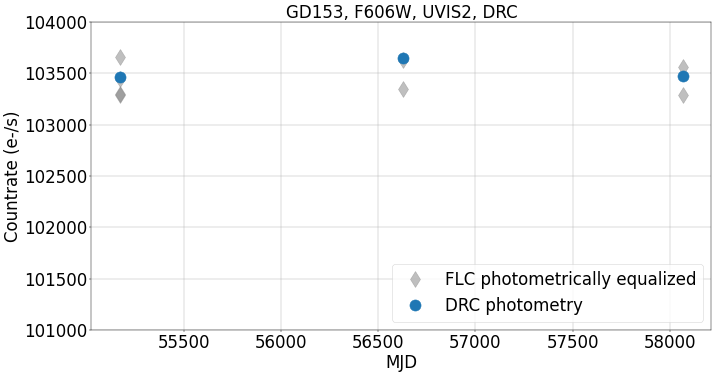

In [20]:
fig = plt.figure(figsize=(20, 10), dpi=40)

plt.plot(df['MJD'], df['Phot-eq'], 'd', markersize=20, color='grey', label='FLC photometrically equalized', alpha=0.5)
plt.plot(mjds, phots, 'o', markersize=20, label='DRC photometry')
plt.grid()
plt.xlabel('MJD', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Countrate (e-/s)', fontsize=30)
plt.title('GD153, F606W, UVIS2, DRC', fontsize=30)
plt.ylim(101000, 104000)
plt.legend(loc=4, fontsize=30)

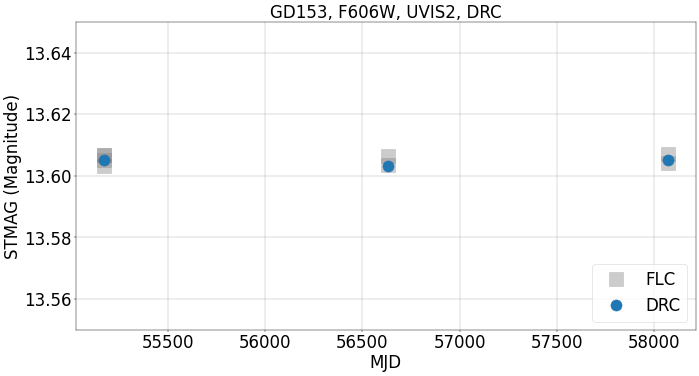

In [21]:
fig = plt.figure(figsize=(20, 10), dpi=40)

plt.plot(df['MJD'], df['STMags'], 's', markersize=25, label='FLC', alpha=0.4, color='Grey')
plt.plot(mjds, mags, 'o', markersize=20, label='DRC')
plt.grid()
plt.ticklabel_format(useOffset=False)
plt.xlabel('MJD', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('STMAG (Magnitude)', fontsize=30)
plt.ylim(13.55, 13.65)
plt.title('GD153, F606W, UVIS2, DRC', fontsize=30)
plt.legend(loc=4, fontsize=30)

<a id="conclusions"></a>
## 7. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Computing aperture photometry and magnitudes on:
    - FLC frames using new time-dependent photometry keywords.
    - FLC frames with equalized countrate values.
    - DRC frames produced from corrected FLCs.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see section 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Harish Khandrika, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2021-09-10

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `drizzlepac`, and `photutils` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)
* [Citing `photutils`](https://photutils.readthedocs.io/en/stable/license.html)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 